In [1]:
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler
#globals
TOTAL_FEATURES = 8
BACK_CANDLES = 100
FUTURE_DAYS = 10

def create_stock_dictionary():
    dictionary = {}
    current_directory = os.getcwd()
    folder_name = 'S&P500'
    folder_path = os.path.join(current_directory, folder_name)

    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            name = file_name.split("_")[0]
            file_path = os.path.join(folder_path, file_name)
            dictionary[name] = pd.read_csv(file_path)
            
    return dictionary

In [2]:
import random
stock_data = create_stock_dictionary()


In [3]:
from sklearn.model_selection import train_test_split
n_days = BACK_CANDLES
m_days = FUTURE_DAYS
stock_data_training = {}
stock_data_testing = {}

#split data for training
for i in stock_data.keys():
    #add more features here
    stock_data[i].rename(columns = {'Datetime':'Date'}, inplace = True)
    stock_data[i]['MACD'] = ta.macd(stock_data[i]['Close'])['MACD_12_26_9']
    stock_data[i]['OBV'] = ta.obv(stock_data[i]['Close'], stock_data[i]['Volume'])
    stock_data[i]['RSI'] = ta.rsi(stock_data[i]['Close'])
    stock_data[i]["TargetNextClose"] = stock_data[i]["Adj Close"].shift(-1)
    stock_data[i].drop(['Close', 'Volume'], axis=1, inplace=True)
    
    #change scaling algorithm
    scaler = MinMaxScaler()
    for k in range(1, stock_data[i].shape[1]):
        column_data = stock_data[i].iloc[:, k].values.reshape(-1, 1)
        stock_data[i].iloc[:, k] = scaler.fit_transform(column_data)
    
    stock_data_training[i], stock_data_testing[i] = train_test_split(stock_data[i], test_size=0.2, shuffle=False)


In [5]:
#code that lets you select which stocks you want to train on, so you can use other stocks to train
vals = stock_data_training.keys()
training_vals = random.sample(list(vals), 8)
training_df_list = []
for key in stock_data_training.keys():
    for item in training_vals:
        if(key == item):
            training_df_list.append(stock_data_training[key])
            

stacked_stock_data = pd.concat(training_df_list, ignore_index=True, axis=0)
stacked_stock_data = stacked_stock_data.dropna()
stacked_stock_data


,Date,Open,High,Low,Adj Close,MACD,OBV,RSI,TargetNextClose
25,2022-04-12 13:30:00-04:00,0.420570,0.412527,0.415348,0.411564,0.582070,0.333957,0.513369,0.407811
26,2022-04-12 14:30:00-04:00,0.410985,0.405949,0.414617,0.407811,0.574508,0.330204,0.482212,0.411656
27,2022-04-12 15:30:00-04:00,0.407176,0.405164,0.414816,0.411656,0.571880,0.334294,0.517210,0.444263
28,2022-04-13 09:30:00-04:00,0.415712,0.440605,0.424170,0.444263,0.598746,0.350164,0.722403,0.454340
29,2022-04-13 10:30:00-04:00,0.444024,0.445710,0.449445,0.454340,0.628363,0.356370,0.764184,0.451067
...,...,...,...,...,...,...,...,...,...
21060,2023-10-17 09:30:00-04:00,0.460602,0.479245,0.463025,0.484582,0.460176,0.755875,0.570258,0.489973
21061,2023-10-17 10:30:00-04:00,0.484444,0.482884,0.494373,0.489973,0.470036,0.758566,0.605868,0.494771
21062,2023-10-17 11:30:00-04:00,0.490700,0.490987,0.502633,0.494771,0.481272,0.762756,0.636315,0.479078
21063,2023-10-17 12:30:00-04:00,0.495434,0.487291,0.491380,0.479078,0.477060,0.759359,0.503196,0.466173


In [6]:
xs, ys = [], []
#for actuallly training data
for i in range(len(stacked_stock_data) - n_days - m_days + 1): 

    v = stacked_stock_data.iloc[i:(i + n_days), :-1]

    if v['Date'].iloc[-1] <= v['Date'].iloc[0]: 
        continue

    xs.append(v.iloc[:, 1:].to_numpy())
    ys.append(stacked_stock_data.iloc[i + n_days:i + n_days + m_days, len(stacked_stock_data.columns) - 1])
xs = np.array(xs)
ys = np.array(ys)


In [7]:
xs[0]

array([[0.42056992, 0.41252697, 0.41534769, 0.41156418, 0.58207041,
        0.33395706, 0.5133694 ],
       [0.41098455, 0.40594928, 0.41461736, 0.4078105 , 0.57450763,
        0.33020384, 0.48221155],
       [0.40717639, 0.40516392, 0.41481636, 0.41165627, 0.57187955,
        0.33429399, 0.51721027],
       [0.41571192, 0.44060477, 0.42417015, 0.44426264, 0.59874591,
        0.35016399, 0.7224028 ],
       [0.4440241 , 0.44570981, 0.44944521, 0.45434043, 0.6283628 ,
        0.35636958, 0.76418413],
       [0.454056  , 0.44636425, 0.45667611, 0.45106663, 0.64791361,
        0.35253836, 0.73545696],
       [0.45077312, 0.44970222, 0.45866629, 0.45566833, 0.66636466,
        0.35637537, 0.75522707],
       [0.45510655, 0.44728053, 0.45707413, 0.45070512, 0.67523059,
        0.35192307, 0.71008043],
       [0.45031346, 0.44456443, 0.45773756, 0.45326893, 0.68318517,
        0.35649494, 0.72256319],
       [0.45267715, 0.44714971, 0.4613198 , 0.45563553, 0.69015955,
        0.36135543, 0.7

In [20]:
X_test = []
Y_test = []
test = random.sample(training_vals, 1)[0]
for key, df in stock_data_testing.items():
    if(key == test):
        if len(df) >= n_days + m_days:
            for i in range(len(df) - n_days - m_days + 1):
                X_test.append(df.iloc[i:i+n_days, 1:-1].to_numpy())

            for i in range(len(df) - n_days - m_days + 1):
                Y_test.append(df.iloc[i+n_days:i+n_days+m_days, -1].to_numpy())

X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [9]:
from keras.layers import LSTM
from keras.layers import Dense
import tensorflow as tf
from keras import Sequential
from keras import optimizers
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Dense, GRU, LeakyReLU
import keras_tuner as kt
import keras
from keras_tuner import HyperParameters, RandomSearch

num_features = 7

In [10]:
def build_model(hp):
    model = Sequential()
    # automatic tuning stuff (that hopefully works)
    num_layers = hp.Int('num_layers', 1, 3)
    for i in range(num_layers):
        model.add(LSTM(units=hp.Int('units_' + str(i), min_value=20, max_value=200, step=20),
                       activation='relu',
                       input_shape=(n_days, num_features) if i == 0 else None,
                       return_sequences=i < num_layers - 1))
    model.add(Dense(m_days, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    project_name='lstm_tuning'
)

tuner.search(xs, ys, epochs=5, batch_size=32, validation_split=0.2, callbacks=[keras.callbacks.EarlyStopping(patience=3)])
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best model architecture:")
best_model.summary()
print("Best hyperparameters:")
for param, val in best_hps.values.items():
    print(f"{param}: {val}")

Trial 10 Complete [00h 32m 01s]
val_loss: 0.001407923991791904

Best val_loss So Far: 0.0013210737379267812
Total elapsed time: 02h 54m 23s
Best model architecture:


c:\Users\Rober\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 40)             │         7,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           410 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,090 (31.60 KB)

 Trainable params: 8,090 (31.60 KB)

 Non-trainable params: 0 (0.00 B)

Best hyperparameters:
num_layers: 1
units_0: 40
units_1: 140
units_2: 40


In [12]:
model = Sequential()
num_layers = best_hps['num_layers']
amount_of_units_0 = 140
amount_of_units_1 = 60
amount_of_units_2 = 80
amount_of_units = 0
for i in range(num_layers):
    model.add(LSTM(units=best_hps['units_' + str(i)],
                    activation='relu',
                    input_shape=(n_days, num_features) if i == 0 else None,
                    return_sequences=i < num_layers - 1))
model.add(Dense(m_days, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(xs, ys, epochs=5, batch_size=32, validation_split=0.2, callbacks=[keras.callbacks.EarlyStopping(patience=3)])

c:\Users\Rober\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
502/502 ━━━━━━━━━━━━━━━━━━━━ 50s 91ms/step - loss: 0.0339 - val_loss: 0.0018
Epoch 2/5
502/502 ━━━━━━━━━━━━━━━━━━━━ 45s 89ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 3/5
502/502 ━━━━━━━━━━━━━━━━━━━━ 55s 109ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 4/5
502/502 ━━━━━━━━━━━━━━━━━━━━ 41s 81ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 5/5
502/502 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - loss: 0.0020 - val_loss: 0.0015


In [13]:
y_pred = model.predict(X_test)


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step


In [14]:
y_pred.shape

(561, 10)

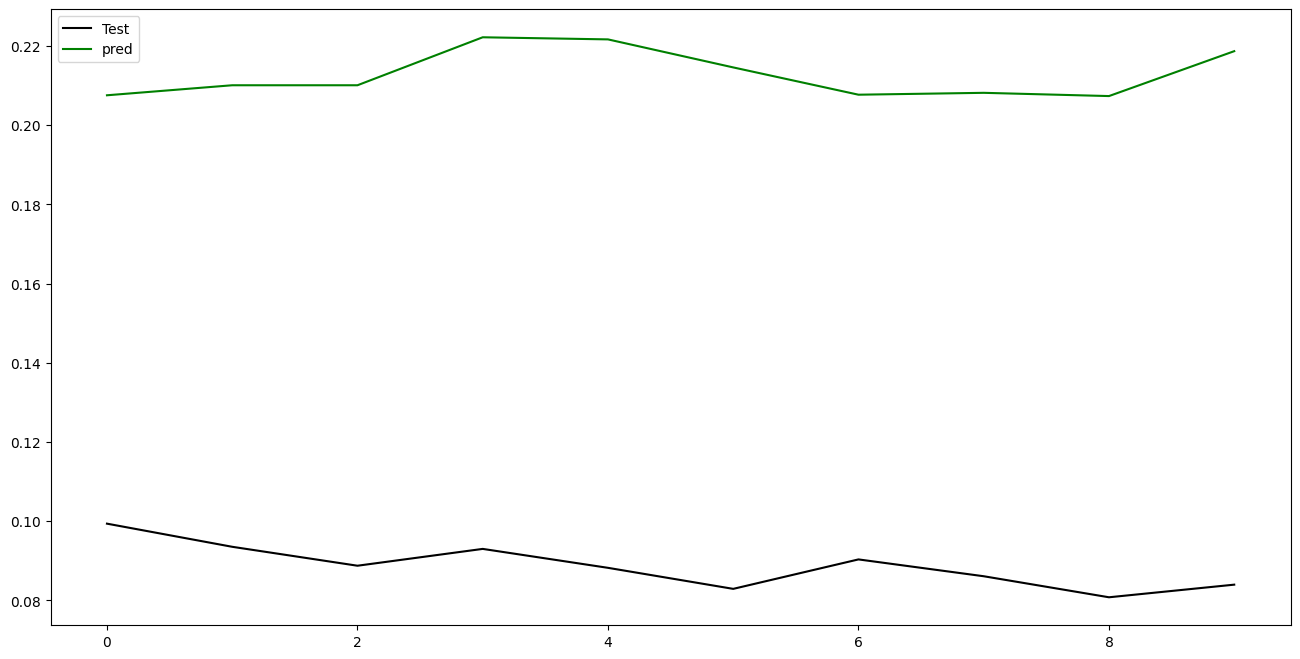

In [21]:
plt.figure(figsize=(16,8))
plt.plot(Y_test[0], color = 'black', label = 'Test')
plt.plot(y_pred[0], color = 'green', label = 'pred')
plt.legend()
plt.show()